# Threading

The ```threading``` library (documentation [here](https://docs.python.org/3/library/threading.html)) is a library which (since Python 3.7) is included by default as part of the Python standard library. It allows us to spawn and run multiple threads concurrently. We will see that it has some significant limitations, but has its uses and is also a good vehicle for learning about concurrency.

## Threads
A thread is a separate flow of execution within your code. Normally, Python executes on a single thread, but the ```threading``` library allows us to create multiple threads. This allows for there to be multiple point in a code where the code is currently being executed. Each thread will have access to the same memory space, so they can share data between them.

## Creating a thread

We can create a thread using the ```Thread``` class from the ```threading``` library and passing a function to the constructor. We do this by writing ```target=[function name]``` in the argument list. We can also pass arguments to the function by writing ```args=``` and then a tuple containing the arguments in the argument list.

 We can then start the thread by calling the ```start()``` method of the thread object. In the example below, we create two threads and start them.


In [1]:
import threading

# Define a simple function to call
def greetings(thread_number):
    print(f'Hello from thread {thread_number}')


for i in range(2):
    # Create a thread to run the greetings function
    # Pass the thread number as an argument in a tuple
    # As a reminder, we can create a tuple with a single element by adding a comma after the element
    t = threading.Thread(target=greetings, args=(i,))
    t.start()

Hello from thread 0
Hello from thread 1


## Waiting for a Thread

Once the thread has finished executing the function, it will be terminated. However, in the meantime, the main thread will continue to execute. If we want to wait for a thread to finish, we can call the ```join()``` method on the thread object. This will block the main thread until the thread has finished executing. When doing this it may be useful to create a collection storing a reference to each thread so we can access them later. For example:

In [2]:
import time

# Create a list to hold references to the threads
threads = []

def wait_for_time(thread_number, seconds):
    # time.sleep will pause the current thread for the given number of seconds
    time.sleep(seconds)
    print(f'Thread {thread_number} waited for {seconds} seconds')

# Create 5 threads that will wait for a different amount of time
for i in range(5):
    # Each thread will wait for between 0 and 2 seconds
    ## thread calls the wait function --> sleep()  
    t = threading.Thread(target=wait_for_time, args=(i, i / 2))
    threads.append(t)
    t.start()

# This line will be printed immediately
print('All threads have started')

# Wait for all threads to finish
for t in threads:
    # a kind of synchronization -- wait untill all threads done    
    t.join()

# This line will only be printed after all threads are done
print('All threads are done!')

Thread 0 waited for 0.0 seconds
All threads have started
Thread 1 waited for 0.5 seconds
Thread 2 waited for 1.0 seconds
Thread 3 waited for 1.5 seconds
Thread 4 waited for 2.0 seconds
All threads are done!


## Getting Values from a Thread

If the function that we pass to the thread has a return value, this value is not stored by default. If we want to access data created in the thread, we have a couple of simple options (and some more complicated ones we won't be covering in this course). We could pass in a mutable object (like a list or dictionary) and have the thread modify that object. For example:

In [3]:
# The number of threads we'll spawn
n = 10

# Create a list with n entries of None
# The results will be stored in this list
results = [None] * n

# A function that will calculate the sum of numbers between 0 and end (inclusive)
def sum_numbers(end, results):
    results[i] = sum(range(end + 1))
# If I do ```del(results)``` here it still runs and gives a result
# why? it's deleting the pointer/variable not the object

# could write wrapper function / leave current untouched and just have a wrapper on top

# Create a list to store the threads
threads = []

# Create n threads
for i in range(0, n):
    # Create a thread to run the sum_numbers function
    # Pass the start and end as arguments in a tuple
    t = threading.Thread(target=sum_numbers, args=(i, results))
    t.start()
    threads.append(t)

for t in threads:
    # Wait for the threads to finish
    t.join()

print(results)

[0, 1, 3, 6, 10, 15, 21, 28, 36, 45]


We could also create a mutable object in the main thread, where the thread can deposit its results. For example, we can adopt the previous example:

In [4]:
import threading

# The number of threads we'll spawn
n = 10

# Create a list with n entries of None
# The results will be stored in this list
results = [None] * n

# A function that will calculate the sum of numbers between 0 and end (inclusive)
def sum_numbers(end):
    # There is no local variable results in this function
    # So Python will look for a global variable called results
    results[end] = sum(range(end + 1))

# Create a list to store the threads
threads = []

# Create n threads
for i in range(0, n):
    # Create a thread to run the sum_numbers function
    # Pass the start and end as arguments in a tuple
    t = threading.Thread(target=sum_numbers, args=(i, ))
    t.start()
    threads.append(t)

for t in threads:
    # Wait for the threads to finish
    t.join()

print(results)

[0, 1, 3, 6, 10, 15, 21, 28, 36, 45]


## Exercise: Sum of Squares

In the code cell below, write some code which will calculate and print the sum of the squares of all of the numbers between 1 and 1,000,000:

$$
\sum_{i=1}^{1000000} i^2 = 1^2 + 2^2 + \ldots + 1000000^2
$$

You should split the work between two threads using the ```threading``` library. Each thread should calculate the sum of the squares of half of the numbers. The main thread should then combine the results from the two threads to get the final answer. Consider how you might structure your code to do this. The final value should be 333,333,833,333,500,000. A sample solution can be found in the file [sample_solutions/02-threading.ipynb](sample_solutions/02-threading.ipynb).

In [16]:
# import numpy as np
# np.linspace(0,99,100)

In [38]:
import threading

# The number of threads we'll spawn
n = 2
sum_upto_val = 1000000

# Create a list with n entries of 0
# The results will be stored in this list
results = [0] * n

# for thread 1 --> apply function on '0 to tot/n'
# for thread 2 --> apply function on 'tot/n to tot*2/n' 
# ..and so on
def sum_squares(thread_ix,tot_val=sum_upto_val,num_thread=n):

    # need to include the given tot_val number in the sum
    last_val = 0
    if thread_ix==num_thread-1:
        last_val = tot_val+1
    else:
        last_val = int(tot_val/n)*(thread_ix+1)

    # print(f'from {int(tot_val/n)*(thread_ix),last_val}')

    for j in range(int(tot_val/num_thread)*(thread_ix),last_val):
        results[thread_ix] += j**2

# Create a list to store the threads
threads = []

# Create n threads
for i in range(0, n):
    # Create a thread to run the sum_numbers function
    # Pass the start and end as arguments in a tuple
    t = threading.Thread(target=sum_squares, args=(i, ))
    t.start()
    threads.append(t)

for t in threads:
    # Wait for the threads to finish
    t.join()

print(sum(results))

333333833333500000


## Order of Execution
When multiple threads are running, we cannot guarantee which order operations across each thread will be executed. Examine the code below, then run it.

In [44]:
# code might have outputs in weird syntaxts/line breaks because of 'buffers' 

import threading
import time

def print_numbers(n, thread_number):
    for i in range(n):
        time.sleep(0.01)
        print(f'Thread: {thread_number}, Number: {i}')


for i in range(5):
    t = threading.Thread(target=print_numbers, args=(5, i))
    t.start()

Thread: 0, Number: 0Thread: 1, Number: 0
Thread: 2, Number: 0

Thread: 3, Number: 0
Thread: 4, Number: 0
Thread: 1, Number: 1
Thread: 2, Number: 1
Thread: 0, Number: 1
Thread: 3, Number: 1
Thread: 4, Number: 1
Thread: 1, Number: 2
Thread: 0, Number: 2
Thread: 2, Number: 2
Thread: 3, Number: 2
Thread: 4, Number: 2
Thread: 1, Number: 3
Thread: 0, Number: 3
Thread: 2, Number: 3
Thread: 3, Number: 3
Thread: 4, Number: 3
Thread: 1, Number: 4
Thread: 0, Number: 4
Thread: 2, Number: 4
Thread: 3, Number: 4
Thread: 4, Number: 4


When we run the code above, we see a couple of interesting things. Firstly, when we examine the order of the output, we may see that a thread that is started later may overtake a thread that started earlier, despite them each running identical code. Secondly, if we run the codes multiple times, the order in which the print statements executes may change. These two observations are due to the way that CPU time is allocated to threads, which is controlled by the operating system. This means we cannot guarantee the order in which threads will execute. This is a common feature of concurrent programming, and is something we will need to be aware of when writing concurrent code.

Another feature that we may see is that some print statements may be on the same line. This is because a single print statement includes printing the output, and then starting a new line. One print statement may have printed its output but not started a new line before another print statement has printed its output. This leads to the outputs of multiple print statements becoming interleaved. 

## Race Conditions

In the example above the exercise, we saw that the function ```sum_numbers``` will be running in multiple threads simultaneously. In each of these threads, the global variable ```results``` will be accessed and modified. In that case, each thread was accessing a different entry in ```results``` and so the different threads didn't interfere with each other. However, if multiple threads are accessing the same data, there can be problems where the threads interfere with each other. This is known as a race condition. For example, in the code below, we write a function which increases the value of the global variable ```x``` by the thread number. Naively, we might expect this to mean that the value of ```x``` at the end of the code running will be equal to the sum of the thread numbers. However, this is not the case.

In [ ]:
import time
import threading

# This is the shared variable that will be incremented by all threads
x = 0

def increment_x_by_thread_number(thread_number):
    # This function will increment x by the thread number

    # We need to tell Python that we're using the global x
    global x

    # Create a local variable to hold the value of x and increment it
    local_x = x
    local_x += thread_number

    # Pause for a moment before updating the global x
    time.sleep(0.1)
    x =local_x

# Run each of the threads
threads = []

for i in range(5):
    t = threading.Thread(target=increment_x_by_thread_number, args=(i,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

# What will the value of x be?
print(x)

# we see that the value is 4 when we expect 1+2+3+4 --> it wont happen bc threads access x = 0 and add their val -
# so the expected value is that of the thread writing last
# sleep to force the race condition --> if we remove it (time to initialize thread is longer than time to run it so it runs fine)

4


In the code above, each thread will start at roughly the same time and the value of ```local_x``` will take the value of ```x```. As the value hasn't been updated in any thread, the value of ```local_x``` will be 0 in each thread. Each thread will pause for a moment before changing the global variable ```x```. The order in which these updates to ```x``` happen is not guaranteed as one thread may overtake another. The final value of ```x``` will be the number of the thread which finishes last. 

Even though the function in each thread increments ```x``` by the number of that thread, the final value of ```x``` will not be the sum of the thread numbers. This is an example of what is known as a "race condition", where the code executing an a thread may be working with outdated values, or may overwrite the work of another thread. This can lead to unpredictable behaviour and bugs in your code. 

In this example, we guaranteed a race condition would occur. But, as the order in which the operations in the thread execute is not guaranteed, it is not uncommon for race conditions to occur sometimes but not others in threaded code. This makes it difficult to debug and test threaded code.

For this reason, when working with threads, you should think carefully about which bits of data your a function run in a thread might be accessing or writing and whether this could change during the execution of the thread. 

## Locks

One way to prevent threads interfering with shared data while other threads may be using it is to use a lock. A lock is an object which can be acquired by a thread. If a thread tries to acquire a lock that is already acquired by another thread, the thread will pause until the lock is released. This can be used to temporarily pause a thread while shared data is being accessed by another thread. We can create a thread by writing ```threading.Lock()``` and acquire a lock by writing ```lock.acquire()```. We can release a lock by writing ```lock.release()```. For example, the code below adapts the previous example to use a lock:

In [ ]:
import time
import threading

# This is the shared variable that will be incremented by all threads
x = 0

lock = threading.Lock()

def increment_x_by_thread_number(thread_number):
    # This function will increment x by the thread number

    # We need to tell Python that we're using the global x -- because integers are immutable
    # lists are mutable so we did not need to take it from the globalNamespace
    global x

    # Acquire the lock here
    # This will prevent other threads from modifying x while we're using it
    lock.acquire()

    # Create a local variable to hold the value of x and increment it
    local_x = x
    local_x += thread_number

    # Pause for a moment before updating the global x
    time.sleep(0.1)
    x =local_x

    # We're done with x, so release the lock
    lock.release()

# Run each of the threads
threads = []

for i in range(5):
    t = threading.Thread(target=increment_x_by_thread_number, args=(i,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

# What will the value of x be?
print(x)
# 10 in this case, 'x' is a shared memory object -> so we lock it while a thread accesses it
# in this case - it kinda makes the code serial again -> careful design decisions when it comes to locks

# what's an example or a common situation when we might want to use locks? 
# --> if the part of the code that uses a lock has a smaller runtime than the computation bit
# lock on shared value but have the computation that is time intensive take place without a lock 

10


In the example above, the function acquires the lock before accessing the global variable ```x```. This means that only one thread can access the global variable ```x``` at a time. Other threads will wait until this thread has finished performing calculations using ```x``` and updating its value before they can access it. This solves the problem we had before where the value of ```x``` was not the sum of the thread numbers.

However, in the example above each thread will be performing their calculations one after another, meaning the code is not parallel, even though it is concurrent. This means that we are not getting the full benefit of using threads. This means that we need to be careful when using locks, as they can slow down the execution of our code. We should only use locks when we need to, and try to keep the amount of code that is protected by a lock to a minimum.

## The Global Interpreter Lock

The Global Interpreter Lock (GIL) is a feature of the Python interpreter which means that only one thread can execute Python code at a time. This means that even if we have multiple threads, only one of them can be executing Python code at a time. This means that the GIL can limit the performance benefits of using threads in Python, particularly when the threads are executing a lot of native Python code. 

For example, the code below calculates the sum of all numbers between 1 and ```n``` using a single thread and then again using ```n_threads``` threads. The code reports the time each version takes to run. Note that, if you're using GitHub Codespaces to run this code, you may need to follow [these instructions](https://docs.github.com/en/codespaces/customizing-your-codespace/changing-the-machine-type-for-your-codespace) to increase the number of cores your Codespace uses.

In [ ]:
import time
import threading

# SINGLE THREAD VERSION
time.start = time.time()

n = 10000000

# Sum the numbers
result = 0

for i in range(n):
    result += i

print(f'Single-thread time taken: {time.time() - time.start}')

# MULTI-THREAD VERSION
# Runs on n_thread threads
n_threads = 2
time.start = time.time()

results = [0] * n_threads

# GIL -- means that we can only execute one thread at a time / one line at a time
# concurrent but not really parallel
def sum_numbers(start, end, thread_number):
    for i in range(start, end):
        results[thread_number] += i

threads = []

# Create n threads to sum the numbers
n_per_thread = n // n_threads

for i in range(n_threads):
    t = threading.Thread(target=sum_numbers, args=(i * n_per_thread, (i + 1) * n_per_thread, i))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

result = sum(results)

print(f'Multi-thread time taken: {time.time() - time.start}')


Single-thread time taken: 0.8976459503173828
Multi-thread time taken: 0.6435384750366211


The times each version of the code takes to run will vary a little each time it's run, particularly for lower values of ```n```. However, we can still compare the runtime for different values of ```n``` and ```n_threads``` in the figure below:

<p align="center">
<img src="resources/threading_sum.png" alt="A figure showing the runtime for different numbers of threads as a function of n" class="center">
</p>

We can see that the time taken to run the code with multiple threads is not significantly faster than the time taken to run the code with a single thread and does not decrease as we use more threads. This is because the GIL is preventing the threads from truly running in parallel. This is an example of the GIL limiting the performance benefits of using threads in Python. For low values of ```n``` the single-threaded code is faster than the multi-threaded code. This is because the overhead of creating and managing threads is greater than the small benefits provided by using multiple threads.

## So Why Use Threads?

Given the limitations of the GIL, you may be wondering why you would use ```threading``` at all. The reason is that there are certain tasks where the execution of Python code is not the main bottleneck in the performance of the code.

### I/O Bound Tasks

Some tasks are input/output (I/O) bound. This means that the task is waiting for some input or output to be completed before it can continue. For example, reading from a file, downloading data from the internet, or waiting for a user to input data are all I/O bound tasks. In these cases, the GIL is not a bottleneck as there is no Python code being interpreted. This means that we can use threads to run other tasks while we are waiting for the I/O bound task to complete.

For example, the code below shows two different ways of writing several files - one sequentially and one where each thread writes a different file.

In [ ]:
import time
import threading
import numpy as np

def write_data_string(data, i):
    # Write the data string to a file
    with open(f'outputs/02_threading/threading_io_{i}.txt', 'w') as f:
        f.write(data)

# Number of data points to generate and number of files
n_data = int(1e6)
n_files = 4

# Create the data
data = np.random.rand(n_data)
# Convert it to a string with newlines between each number
data_string = '\n'.join(map(str, data))

# SERIAL VERSION
start_time = time.time()

for i in range(n_files):
    # Call the function repeatedly
    write_data_string(data_string, i)

print(f'Single thread time: {time.time() - start_time}s')

# MULTI-THREADED VERSION
start_time = time.time()
threads = []

for i in range(n_files):
    # Create the threads and set them running
    t = threading.Thread(target = write_data_string, args = (data_string, i))
    t.start()
    threads.append(t)

# Wait for the threads to finish
for t in threads:
    t.join()

print(f'Multi-thread time: {time.time() - start_time}s')
# If the underlying module is written in Python --> this bypassing of GIL trick won't work as well
# think about what's happening under the hood & then decide if to use GIL or not

Single thread time: 0.09949398040771484s
Multi-thread time: 0.052796125411987305s


The above code shows a reasonable speed-up of the writing of the files. This is because each thread is writing files, rather than interpreting new lines of Python code. This means the GIL isn't forcing each thread to wait, allowing the threads to run more in parallel.

### Non-Python Code

It's possible to write code in Python which runs non-Python code. When this happens, it's possible to release the GIL, allowing multiple copies of the code to run concurrently in different threads. This may in code you've written yourself or in a package you're using.

For example, the ```numpy``` package is made up primarily of compiled C code and so functions in this package do not execute Python commands while it is running and release the GIL while running. This means that we can use threads to run multiple ```numpy``` operations concurrently. This can be useful when we have many expensive ```numpy``` operations to run and the bottleneck is the time taken to run these operations, rather than the time taken to run the Python code. For instance, the code below applies a series of 8 different functions to an array of ```n``` numbers. The single-threaded version of the code applies each sequentially, whilst the multi-threaded version of the code splits the operations across ```n_threads``` threads.

In [60]:
import time
import numpy as np

# The number of values we'll be taking the sin of
n = int(1e7)

# Generate n random numbers
x = np.random.rand(n)

# it goes off and does numpy executions -- doesn't need the GIL
functions = [np.sin, np.cos, np.tan, np.arcsin, np.arccos, np.arctan, np.exp, np.log]

# SINGLE THREAD VERSION
time.start = time.time()

# Apply each function to the array
for i in range(8):
    functions[i](x)

print(f'Single-thread time taken: {time.time() - time.start}')

# MULTI-THREAD VERSION
# Runs on n_thread threads
n_threads = 4
time.start = time.time()

def add_vector_partial(start, end, x):
    for i in range(start, end):
        functions[i](x)

threads = []

# Create n threads to sum the numbers
n_per_thread = 8 // n_threads

for i in range(n_threads):
    t = threading.Thread(target=add_vector_partial, args=(i * n_per_thread, (i + 1) * n_per_thread, x))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

print(f'Multi-thread time taken: {time.time() - time.start}')

Single-thread time taken: 0.5218634605407715
Multi-thread time taken: 0.295318603515625


The runtimes are shown below:

<p align="center">
<img src="resources/threading_numpy_functions.png" alt="A figure showing the runtime for different numbers of threads as a function of n" class="center">
</p>

As before, for small values of ```n```, the multi-threaded code is slower then the single-threaded coded because of the overhead of setting up multiple threads. For larger values of ```n``` though, the extra threads make a difference, with the 8-thread version of the code running about three times quicker than the single-threaded version of the code. 

This is still not a perfect speedup. Part of this is because each each function we call may take a different time to run, and the 8-thread version will have to wait for the slowest function. This is an example of "load-balancing": the idea that parallel code will perform best when each parallel task takes the same amount of time to run. This is something the example above likely doesn't do perfectly.

Another reason the example above doesn't achieve a perfect speedup is that much of Numpy is already parallelized. This means that even the single-threaded version of the code is already running multiple operations concurrently. This means that the speedup we get from using multiple threads is less than it would be if we were running code that was not already parallelized. This also means that trying to use threading to speed up a single Numpy operation is not normally effective as Numpy is already using multiple threads in a near optimal way. However, if there are several different Numpy operations which need to be run, then threading can allow them to be performed concurrently with at least some speedup.

### An Escape from the GIL?

[Python 3.13.0](https://docs.python.org/3/whatsnew/3.13.html) introduced [experimental support](https://docs.python.org/3/howto/free-threading-python.html) for a version of Python where the GIL is disabled. This "free-threaded" version of Python is intended to be bypass the limitations we've seen above. However, it it is currently around 40% slower than the standard version of Python for single-threaded tasks and, as a result, this is not part of the standard Python 3.13 distribution. When I experimented with this, I found it difficult to get working. This feature may become easier to use and more important in the future.

## Exercise

In the directory ```data``` there are then files named ```threading_0.txt``` to ```threading_9.txt``` which each contain a list of 1,000,000 numbers. The cell below contains some code which creates a [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the collection of all the data in these files. The code reads in the data from each files, combines it into a single ```numpy``` array, then loops through a series of thresholds, counting the number of values in the array which are less than or equal to the threshold. The code then plots the cumulative distribution function.

Your task is to produce a second version of the code which uses multiple threads to achieve this goal. You may use the first version of the code as a guide, particularly if you're less familiar with the Python constructs used in it. Consider how you may split the work between the threads, and check to see if doing so speeds up the code. A sample solution can be found in the file [sample_solutions/02-threading.ipynb](sample_solutions/02-threading.ipynb).

Single-thread time taken: 0.5726943016052246
Multi-thread time taken: 0.5022649765014648


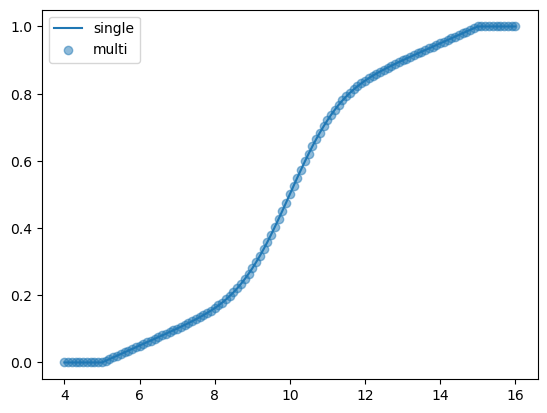

In [ ]:
import threading
import numpy as np
import matplotlib.pyplot as plt
import time

# These are thresholds for the CDF
# Use them in your code
thresholds = np.linspace(4, 16, 121)


# SINGLE-THREAD VERSION
start_time = time.time()

# Load the files into a number of numpy arrays within a list
data_list = [np.loadtxt(f'data/threading_{i}.txt') for i in range(10)]

# Concatenate the arrays in the list into a single array
data = np.concatenate(data_list)

# Create an array to hold the CDF of the same shape as 'thresholds'
cdf = np.zeros_like(thresholds)

# Loop over the thresholds, counting the number of values below each threshold
for i, threshold in enumerate(thresholds):
    cdf[i] = np.sum(data < threshold)

# Divide by the number of values to get the CDF
cdf = cdf / len(data)

print(f'Single-thread time taken: {time.time() - start_time}')

# Plot the CDF
plt.plot(thresholds, cdf,label='single');

# MULTI-THREAD VERSION
start_time = time.time()

# Write you code here

# Runs on n_thread threads -- same as number of files
n_threads = 10

#for lock:
cdf = np.zeros_like(thresholds)
cdf_norm_val = 0 

# without lock:
cdfs = []
cdf_lens = []

lock = threading.Lock()

time.start = time.time()

def find_cdf_lower(thread_val,threshold_vals=thresholds):
    
    data_val = np.loadtxt(f'data/threading_{i}.txt')
    cdf_with_lock = True

    if cdf_with_lock == True:
        # number of vals in data below threshold for each smaller data object
        temp_cdf = np.zeros_like(threshold_vals)
        for j, threshold in enumerate(threshold_vals):
            temp_cdf[j] = np.sum(data_val<threshold)

        # lock cdf and update it -- does it need to be locked??
        lock.acquire()
        global cdf, cdf_norm_val
        cdf += temp_cdf
        cdf_norm_val += len(data_val)
        lock.release()
        
    else:
        # TO AVOID THIS: NEED TO STORE RESULTS IN A LIST OF NUMPY ARRAYS
        # AND THEN COMBINE THEM IN THE END
        pass

threads = []

for i in range(n_threads):
    t = threading.Thread(target=find_cdf_lower, args=(i,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()


print(f'Multi-thread time taken: {time.time() - start_time}')
# Plot the CDF
plt.scatter(thresholds, cdf/cdf_norm_val,label='multi',alpha=0.5);

plt.legend()
plt.show()

In [76]:
# cdf

Multi-thread time taken: 0.09497213363647461


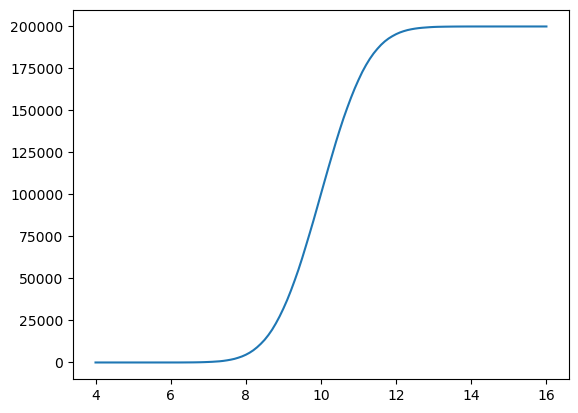

In [ ]:
# thresholds